In [3]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
%matplotlib inline

## Transformada de Fourier en 2D
Podemos interpretar los cambios de intensidad de la imagen como funciones sobre un plano 2D

![SNOWFALL](fourier.png)

In [4]:
# Leemos ambas imagenes
img_low_freq = cv.imread('fft_hf.jpg', cv.IMREAD_GRAYSCALE)
img_hig_freq = cv.imread('fft_lf.jpg', cv.IMREAD_GRAYSCALE)
# Aplico la transformada
img_fft_low = np.fft.fft2(img_low_freq)
img_fft_hig = np.fft.fft2(img_hig_freq)
# llevo la baja frec al origen para acomodar la visualizacion
img_fft_low = np.fft.fftshift(img_fft_low)
img_fft_hig = np.fft.fftshift(img_fft_hig)
# obtengo el modulo
img_fft_low = 20*np.log(np.abs(img_fft_low))
img_fft_hig = 20*np.log(np.abs(img_fft_hig))
# Tomamos un "perfil" de una fila por cada imagen
low_freq_sg = img_low_freq[50,10:60]
hig_freq_sg = img_hig_freq[50,10:60]

Graficamos los resultados

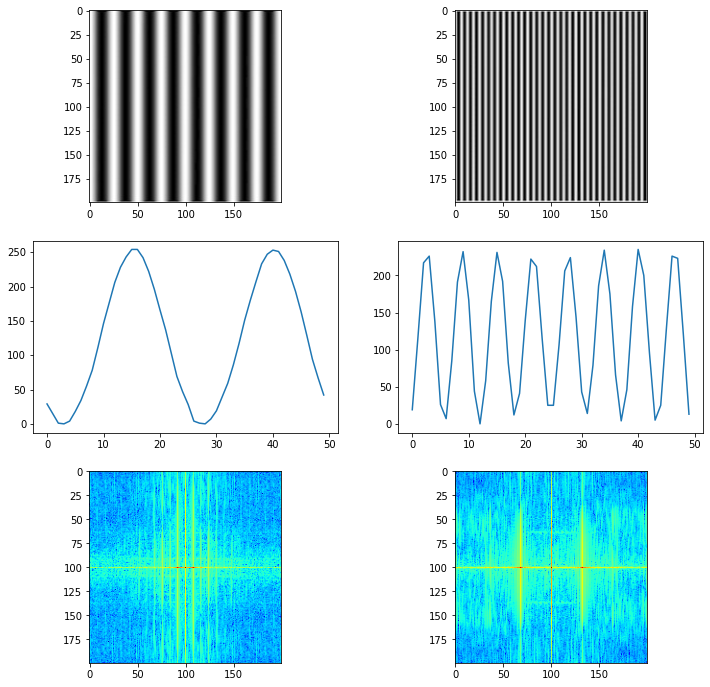

In [5]:
plt.figure(figsize=(12,12))
plt.subplot(3,2,1)
plt.imshow(img_low_freq, cmap='gray')
plt.subplot(3,2,2)
plt.imshow(img_hig_freq, cmap='gray')

plt.subplot(3,2,3)
plt.plot(low_freq_sg)
plt.subplot(3,2,4)
plt.plot(hig_freq_sg)

plt.subplot(3,2,5)
plt.imshow(img_fft_low, cmap='jet')
plt.subplot(3,2,6)
plt.imshow(img_fft_hig, cmap='jet')

plt.show()

## Filtros en el dominio espectral

In [6]:
# funciones auxiliares
def fft2_mod(image):

  shifted_image_fft = np.fft.fftshift(np.fft.fft2(image))
  return 20*np.log(np.abs(shifted_image_fft))


def _filter_round_shape(height, width, radius):
  canvas = np.zeros((height, width))
  return cv.circle(canvas,
                     center=(int(canvas.shape[1]/2), int(canvas.shape[0]/2)),
                     radius=radius,
                     color=(255),
                     thickness=-1).astype(np.uint8)


def create_lp_filter(height, width, radius=20):

  lp_filter = _filter_round_shape(height, width, radius)
  return lp_filter


def create_hp_filter(height, width, radius=60):

  lp_filter = _filter_round_shape(height, width, radius)
  return cv.bitwise_not(lp_filter)

In [7]:
# leo la imagen en escala de grises
img = cv.imread('fft_alfa_pred.png', cv.IMREAD_GRAYSCALE)
# obtengo el modulo de la transformada de fourier
mod = fft2_mod(img)

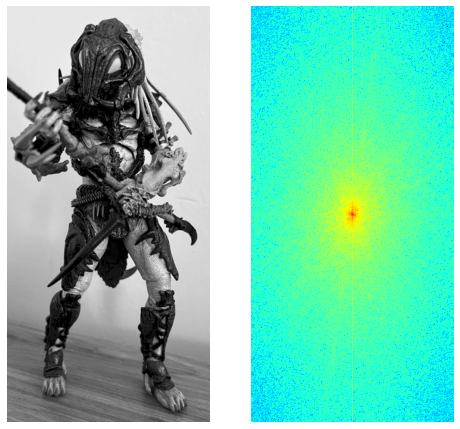

In [8]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(img, cmap='gray')
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(mod, cmap='jet')

### Definimos los filtros en el dominio espectral

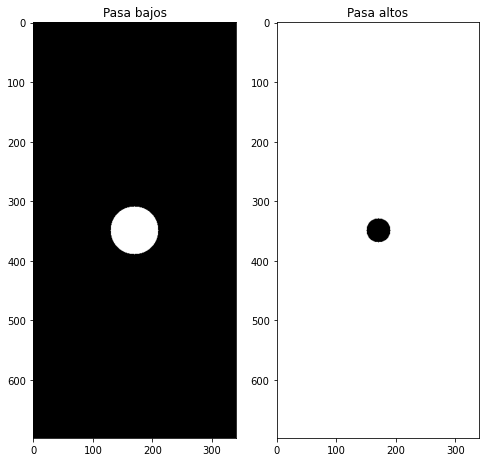

In [9]:
h, w = img.shape
lp_filter = create_lp_filter(h, w, radius=40)
hp_filter = create_hp_filter(h, w, radius=20)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(lp_filter, cmap='gray')
plt.title('Pasa bajos')
plt.subplot(1,2,2)
plt.title('Pasa altos')
plt.imshow(hp_filter, cmap='gray')

### Aplicamos los filtros a la imagen

In [10]:
# vuelvo a calcular la FFT. Para aplicar el filtro 
# necesito la transformada en modulo y fase en el dominio
# de los numeros complejos
shifted_fft = np.fft.fftshift(np.fft.fft2(img))
lp_filtered = shifted_fft * lp_filter
hp_filtered = shifted_fft * hp_filter

# Aplicamos la antitransformada y obtenemos las imagenes filtradas
f_ishift = np.fft.ifftshift(lp_filtered)
img_lp = np.real(np.fft.ifft2(f_ishift))
f_ishift = np.fft.ifftshift(hp_filtered)
img_hp = np.real(np.fft.ifft2(f_ishift))

### Graficamos los resultados

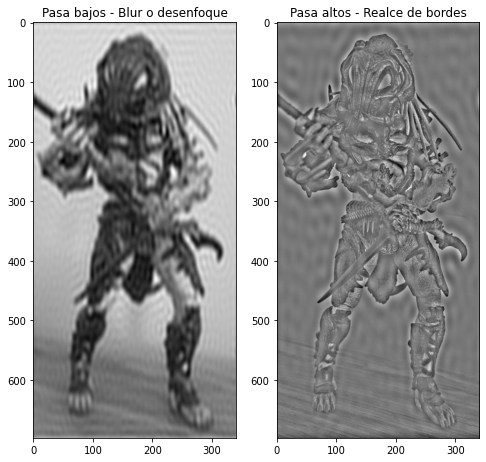

In [11]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(img_lp, cmap='gray')
plt.title('Pasa bajos - Blur o desenfoque')
plt.subplot(1,2,2)
plt.title('Pasa altos - Realce de bordes')
plt.imshow(img_hp, cmap='gray')

In [14]:
# def create_gauss_filter(h, w, k_size=15, sigma=5):
def create_gauss_filter(h, w, k_size=15, sigma=3):
    gauss_kernel = cv.getGaussianKernel(k_size, sigma)
    gauss_kernel = np.outer(gauss_kernel, gauss_kernel)
    gauss_kernel = gauss_kernel / np.sum(gauss_kernel)
    
    # Filtro
    filter_ = np.zeros((h, w))
    row = int(w/2) - int(k_size/2)
    col = int(h/2) - int(k_size/2)
    for i in range(0, k_size):
        for j in range(0, k_size):
            filter_[col + i, row + j] = gauss_kernel[i,j]

    # Transformada del filtro (shifted)
    ft = np.fft.fft2(filter_)
    ft = np.fft.fftshift(ft)

    return filter_, ft

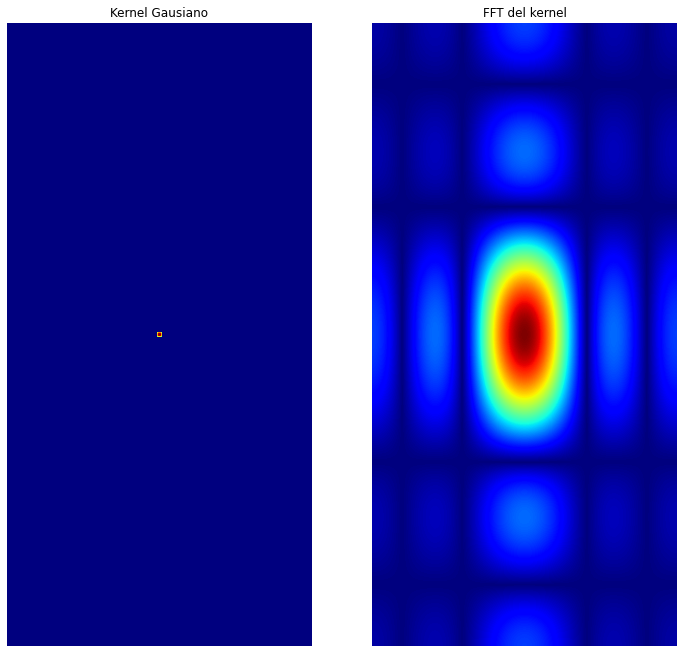

In [15]:
kernel, kernel_tf = create_gauss_filter(h, w, k_size=5, sigma=5)

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.axis('off')
plt.title("Kernel Gausiano")
plt.imshow(kernel, cmap='jet')
plt.subplot(1,2,2)
plt.axis('off')
plt.title("FFT del kernel")
plt.imshow(np.abs(kernel_tf), cmap='jet')

Text(0.5, 1.0, 'Desenfoque gausiano')

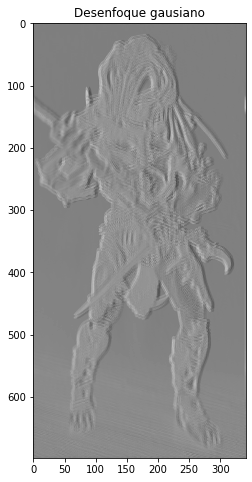

In [18]:
img_fft = np.fft.fft2(img)
filtered = img_fft * kernel_tf

#img_gauss = np.real(np.fft.ifft2(np.fft.ifftshift(filtered)))
img_gauss = np.fft.ifftshift(np.real(np.fft.ifft2(filtered)))

plt.figure(figsize=(8,8))
plt.imshow(img_gauss, cmap='gray')
plt.title('Desenfoque gausiano')